# Note!

The mixed likelihood doesn't expose the hyperparameters of the likelihoods inside it - so these are fixed.

In [1]:
import GPy
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from mix_integral_exponential import Mix_Integral_Exponential
from mixed import Mixed
from scipy.stats import norm
#from squashed_probit import SquashedProbit
from GPy.likelihoods.link_functions import Probit as OldProbit
from shiftedprobit import ShiftedProbit

In [19]:
def squash(fs,variance):
    pb = GPy.likelihoods.link_functions.Probit()
    squashed = []
    grid = np.linspace(-100,100,15000)
    #print(pb.transf(10.0))
    for f in fs.flatten():
        val=np.sum(grid*norm.pdf(f,grid,np.sqrt(variance))*pb.transf(grid*1.0))/np.sum(norm.pdf(f,grid,np.sqrt(variance)))
        #val=np.sum(grid*norm.pdf(f,grid,np.sqrt(variance))*1)/np.sum(norm.pdf(f,grid,np.sqrt(variance)))
        squashed.append(val)
    return np.array(squashed).reshape(fs.shape)

def run_demo(n_non_negs=0,xlim=[0,26],ylim=[-40,50]):
    X = 2.0*np.array([[1,0],[2,1],[3,2],[4,3],[10,9],[11,10],[12,11],[13,12]])
    X = np.c_[X,np.zeros([len(X),1])]
    Y = 10.0*np.array([[7,6,4,1,1,4,6,7]]).T
    Y+=np.random.randn(len(Y),1)*0.1

    fn_idx = np.zeros([len(X),1])
    non_negs_X = np.linspace(0,26,n_non_negs)[:,None]
    non_negs_X = np.c_[non_negs_X,np.zeros([len(non_negs_X),1]),np.ones([len(non_negs_X),1])]
    non_negs_Y = np.ones([len(non_negs_X),1])
    non_negs_fn_idx = np.ones_like(non_negs_Y)
    X = np.r_[X,non_negs_X]
    Y = np.r_[Y,non_negs_Y]
    fn_idx = (np.r_[fn_idx,non_negs_fn_idx]).astype(int)
    scaling = np.ones_like(fn_idx)/10
    Y_metadata = {'likelihood_fn_index':fn_idx}#,'scaling':scaling}
    


    kernel = Mix_Integral_Exponential(3,variances=531.0,lengthscale=[4.36])
    likelihood_fns = [GPy.likelihoods.Gaussian(variance=1.0), GPy.likelihoods.Bernoulli(gp_link=ShiftedProbit(10,1))]

   # print(X)
   # print(Y)
   # print(Y_metadata['likelihood_fn_index'])
    
    m = GPy.core.GP( 
        X, Y,        
        kernel = kernel, 
        inference_method = GPy.inference.latent_function_inference.EP(),
        likelihood = Mixed(likelihood_fns=likelihood_fns),
        Y_metadata = Y_metadata,normalizer=False,
    )

    m.kern.lengthscale.fix()
    m.kern.variances.fix()
    m.optimize(messages=True)
    print(m)

    testX = np.linspace(-5,30,500)[:,None]
    testX = np.c_[testX,np.zeros([len(testX),1]),np.ones([len(testX),1])]
    m.Y_metadata = None

    mu,var = m.predict_noiseless(testX)
    
    mu,K = m.predict_noiseless(testX,full_cov=True)
    sample = np.random.multivariate_normal(mu[:,0],K,size=100)
    
    
    

    if n_non_negs==0: #we assume we want a gaussian likelihood link
        plt.plot(testX[:,0],mu,'b-')
        plt.plot(testX[:,0],mu+np.sqrt(var)*1.96,'b--')
        plt.plot(testX[:,0],mu-np.sqrt(var)*1.96,'b--')
        #plt.plot(testX[:,0],mu+np.sqrt(var)*4,'b:',alpha=0.5)
        #plt.plot(testX[:,0],mu-np.sqrt(var)*4,'b:',alpha=0.5)
        plt.plot(testX[:,0],sample.T,'b-',alpha=0.05);
    else:
        variance = m.likelihood.likelihood_fns[0].variance[0]
        plt.plot(testX[:,0],squash(mu[:,0],variance),'b-')
        plt.plot(testX[:,0],squash((mu-np.sqrt(var)*1.96)[:,0],variance),'b--')
        plt.plot(testX[:,0],squash((mu+np.sqrt(var)*1.96)[:,0],variance),'b--')
        plt.plot(testX[:,0],squash(sample.T,variance),'b-',alpha=0.05);
        plt.plot(testX[:,0],squash(sample[0:1,:].T,variance),'r-',alpha=0.5);
        #plt.plot(testX[:,0],squash((mu-np.sqrt(var)*4)[:,0],variance),'b:',alpha=0.5)
        #plt.plot(testX[:,0],squash((mu+np.sqrt(var)*4)[:,0],variance),'b:',alpha=0.5)
    
    for x,y in zip(X,Y):
        if x[-1]==0:
            plt.plot([x[0],x[1],x[1],x[0],x[0]],[0,0,y/2,y/2,0],'k-')
        else:
            plt.plot([x[0],x[0]],[-1,-2],'r-')
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.hlines(0,xlim[0],xlim[1],colors='k')
    return m,X,Y

nothing to optimize

Name : gp
Objective : 44.36505971254155
Number of Parameters : 2
Number of Optimization Parameters : 0
Updates : True
Parameters:
  gp.                                   |  value  |  constraints  |  priors
  mix_integral_exponential.variances    |  531.0  |   +ve fixed   |        
  mix_integral_exponential.lengthscale  |   4.36  |   +ve fixed   |        


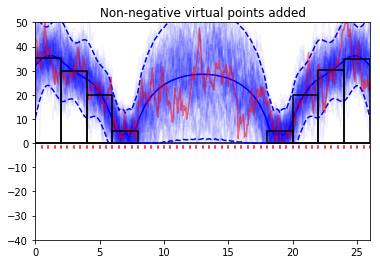

In [20]:
#m,X,Y=run_demo(0)
#plt.title('No non-negative virtual points')
#plt.savefig('gaussian_likelihood.pdf')
#plt.figure()
m,X,Y=run_demo(13*4+1)
plt.title('Non-negative virtual points added')
plt.savefig('probit_virtual_points_exponential.pdf')
#plt.savefig('probit_virtual_points.pdf')
#plt.figure()
#m,X,Y=run_demo(13*4+1,lengthscale=2)
#plt.title('Non-negative virtual points, short lengthscale')
#plt.savefig('shortlengthscale.pdf')